In [1]:
import os
import sys

# Importante, serve a fare in modo che il jupyter notebook possa vedere ed importare i file di libreria che creiamo in questa cartella.
sys.path.insert(0, os.getcwd())

## Selezione dei modelli

# AGGIUNGERE PREDIZIONI MIGLIORI

Dalla cartella `models`, è stato selezionato un modello per notebook in base alla propria performance

Per alcuni notebook vi era solamente un modello:
 - `kNN.ipynb`
 - `SVM.ipynb`
 - `RandomForest.ipynb`
 - `neural_network.ipynb`
 - `DecisionTree.ipynb`
 - `cat_boost.ipynb`
 - `lightGBM.ipynb`

Per gli altri notebook invece è stato selezionato il modello con la migliore performance:
 - `linear_regression.ipynb` - `Ridge`
 - `classic_boosting.ipynb` - `GradientBoosting`


#### Importiamo le librerie

In [2]:
# Importiamo le librerie che ci servono
from sklearn.neighbors       import KNeighborsRegressor
from sklearn.svm             import SVR
from sklearn.ensemble        import RandomForestRegressor
from sklearn.tree            import DecisionTreeRegressor
from catboost                import CatBoostRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from lightgbm                import LGBMRegressor

from sklearn.linear_model import Ridge
from sklearn.ensemble     import GradientBoostingRegressor

from functions.evaluation import Evaluator, EvaluationResult
import functions.load as load
from pandas import read_csv
import numpy as np

2023-02-05 16:29:24.680473: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-05 16:29:25.537222: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-02-05 16:29:25.537274: I tensorflow/compiler/xla/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-02-05 16:29:28.078264: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-

#### Caricamento dei dati
Viene ora caricato il dataset `ridge_features_refined_data.csv`. Abbiamo scelto questo dataset perchè pochi modelli, al di fuori della Random Forest beneficiavano delle features scelte da essa.

Inoltre i dati all'interno di esso sono già stati normalizzati dalla fase di feature selection.

In [3]:
def load_raw():
  df = load.loadDataFrame("./data/raw.arff")
  outliers = df[(df['Gr_Liv_Area'] > 4000) & (df['Sale_Price'] < 200000)].index
  df.drop(outliers, inplace = True)
  return df

# Carichiamo i dati grezzi
raw = load_raw()

#Prendiamo i dati dal file csv ridge
df = read_csv("./data/ridge_features_refined_data.csv")
df.describe().T

count          mean       std          min  \
Lot_Area               2927.0  7.476842e-16  1.000171    -3.775920   
Overall_Qual           2927.0  6.090878e+00  1.406195     1.000000   
Overall_Cond           2927.0  5.563717e+00  1.111960     1.000000   
Mas_Vnr_Area           2927.0  0.000000e+00  1.000171    -0.790677   
Exter_Qual             2927.0  2.396994e+00  0.578344     1.000000   
...                       ...           ...       ...          ...   
Garage_Type_No_Garage  2927.0  5.363854e-02  0.225342     0.000000   
Sale_Type_'WD '        2927.0  8.664161e-01  0.340263     0.000000   
Year_Sold              2927.0  2.007791e+03  1.317120  2006.000000   
Mo_Sold                2927.0  6.215237e+00  2.712368     1.000000   
Sale_Price             2927.0  3.942335e-15  1.000171    -6.289950   

                               25%          50%          75%          max  
Lot_Area                 -0.346207     0.120200     0.514420     6.272148  
Overall_Qual              5.000000     6.000000     7.000000    10.000000  
Overall_Cond              5.000000     5.000000     6.000000     9.000000  
Mas_Vnr_Area             -0.790677    -0.790677     1.156440     2.029755  
Exter_Qual                2.000000     2.000000     3.000000     4.000000  
...                            ...          ...          ...          ...  
Garage_Type_No_Garage     0.000000     0.000000     0.000000     1.000000  
Sale_Type_'WD '           1.000000     1.000000     1.000000     1.000000  
Year_Sold              2007.000000  2008.000000  2009.000000  2010.000000  
Mo_Sold                   4.000000     6.000000     8.000000    12.000000  
Sale_Price               -0.611885    -0.093159     0.614351     3.712303  

[103 rows x 8 columns]

### Ricostruiamo i modelli dai notebook

Recuperiamo i parametri migliori trovati durante l'analisi dei singoli modelli tramite il file JSON salvato dentro data:

In [4]:
#Carichiamo per ogni modello i parametri migliori e li usiamo per creare un oggetto Evaluator
p = load.loadBestParameterModel('KNeighborsRegressor')
KNN = Evaluator(KNeighborsRegressor(**p, n_jobs=4), df, "Sale_Price")

p = load.loadBestParameterModel('SVR')
SVM = Evaluator(SVR(**p), df, "Sale_Price")

p = load.loadBestParameterModel('RandomForestRegressor')
RFR = Evaluator(RandomForestRegressor(**p, n_jobs=4), df, "Sale_Price")

p = load.loadBestParameterModel('DecisionTreeRegressor')
DTR = Evaluator(DecisionTreeRegressor(**p), df, "Sale_Price")

p = load.loadBestParameterModel('CatBoostRegressor')
CBR = Evaluator(CatBoostRegressor(**p, loss_function='RMSE', eval_metric='RMSE', silent=True), df, "Sale_Price")

p = load.loadBestParameterModel('Ridge')
RLR = Evaluator(Ridge(**p), df, "Sale_Price")

p = load.loadBestParameterModel('GradientBoostingRegressor')
GBR = Evaluator(GradientBoostingRegressor(**p), df, "Sale_Price")

p = load.loadBestParameterModel('LGBMRegressor')
LGB = Evaluator(LGBMRegressor(**p), df, "Sale_Price")

#Definiamo la rete neurale
nn = Sequential()
nn.add(Dense(128, activation='relu', input_shape=(df.shape[1]-1,)))
nn.add(Dense(64, activation='relu'))
nn.add(Dense(48, activation='relu'))
nn.add(Dense(32, activation='relu'))
nn.add(Dense(8, activation='linear'))
nn.add(Dense(1, activation='linear'))
nn.compile(optimizer='adam', loss='mse', metrics=['mse'])

SNN = Evaluator(nn, df, "Sale_Price")

2023-02-05 16:29:31.077496: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-05 16:29:31.077524: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-05 16:29:31.077545: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (stefano): /proc/driver/nvidia/version does not exist
2023-02-05 16:29:31.077856: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Ora splittiamo i dataset di ogni valutatore e alleniamo i modelli, estraendo i risultati della cross validation e della valutazione finale tramite il test-set

In [5]:
# Splittiamo i dati per i vari modelli
KNN.split_dataset()
SVM.split_dataset()
RFR.split_dataset()
DTR.split_dataset()
CBR.split_dataset()
SNN.split_dataset()
RLR.split_dataset()
GBR.split_dataset()
LGB.split_dataset()

# Eseguiamo la cross validation temporale per ogni modello
KNN_cv = KNN.temporal_cv()
SVM_cv = SVM.temporal_cv()
RFR_cv = RFR.temporal_cv()
DTR_cv = DTR.temporal_cv()
CBR_cv = CBR.temporal_cv()
SNN_cv = SNN.temporal_cv(epochs=1000)
RLR_cv = RLR.temporal_cv()
GBR_cv = GBR.temporal_cv()
LGB_cv = LGB.temporal_cv()

6/6 [==============================] - 0s 2ms/step
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current 

In [6]:
#Valutiamo i modelli
KNN_res = KNN.evaluate()
SVM_res = SVM.evaluate()
RFR_res = RFR.evaluate()
DTR_res = DTR.evaluate()
CBR_res = CBR.evaluate()
SNN_res = SNN.evaluate(epochs=1000)
RLR_res = RLR.evaluate()
GBR_res = GBR.evaluate()
LGB_res = LGB.evaluate()

31/31 [==============================] - 0s 2ms/step
[LightGBM] [Warning] min_data_in_leaf is set=20, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=20


Per ogni modello viene ora plottato il grafico dei residui insieme alla loro distribuzione

KNearestNeighborsRegressor


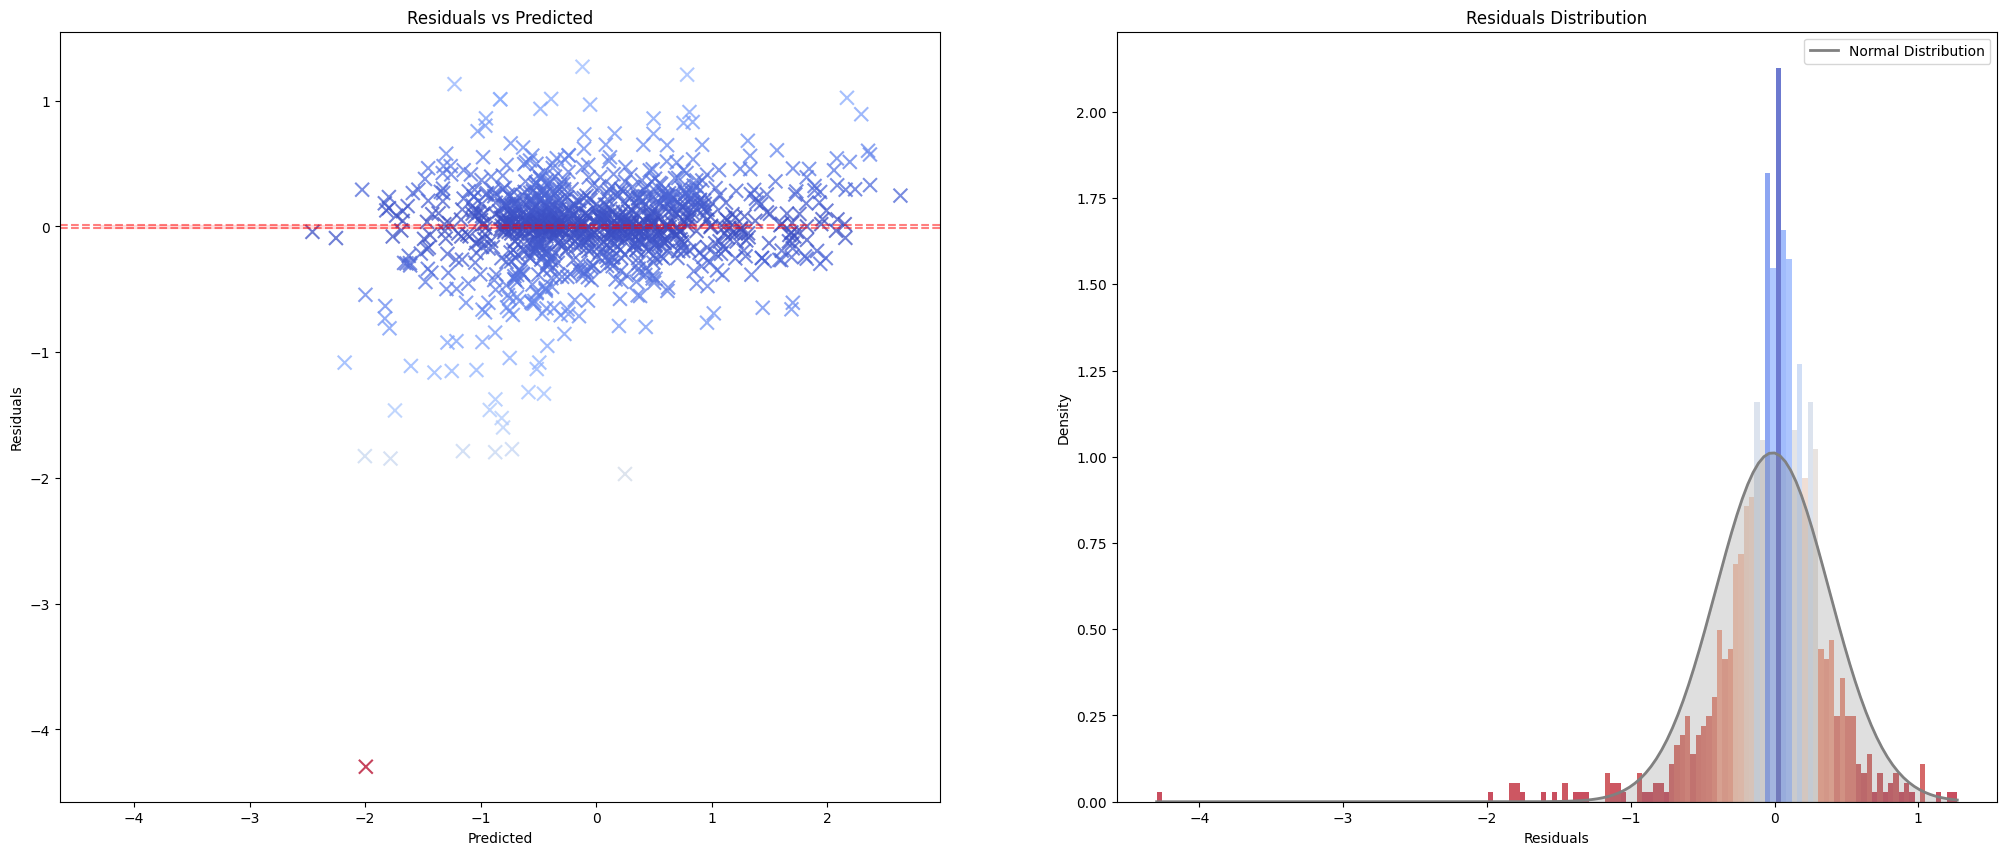

SupportVectorMachine


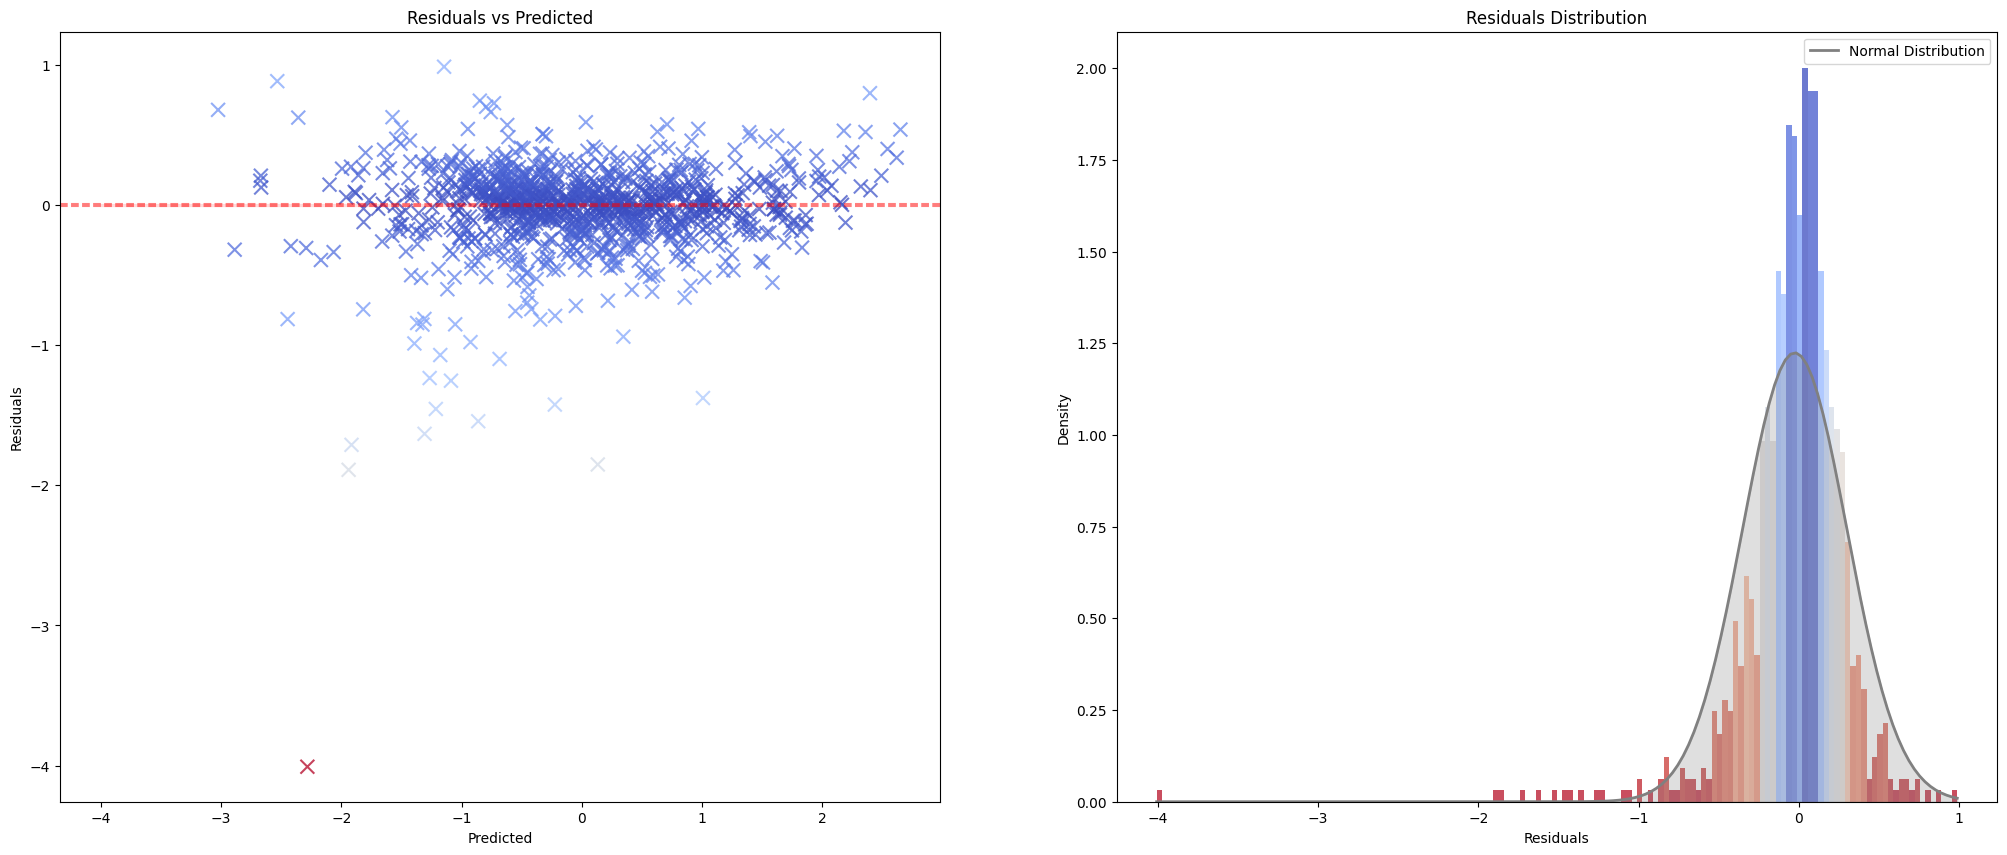

RandomForestRegressor


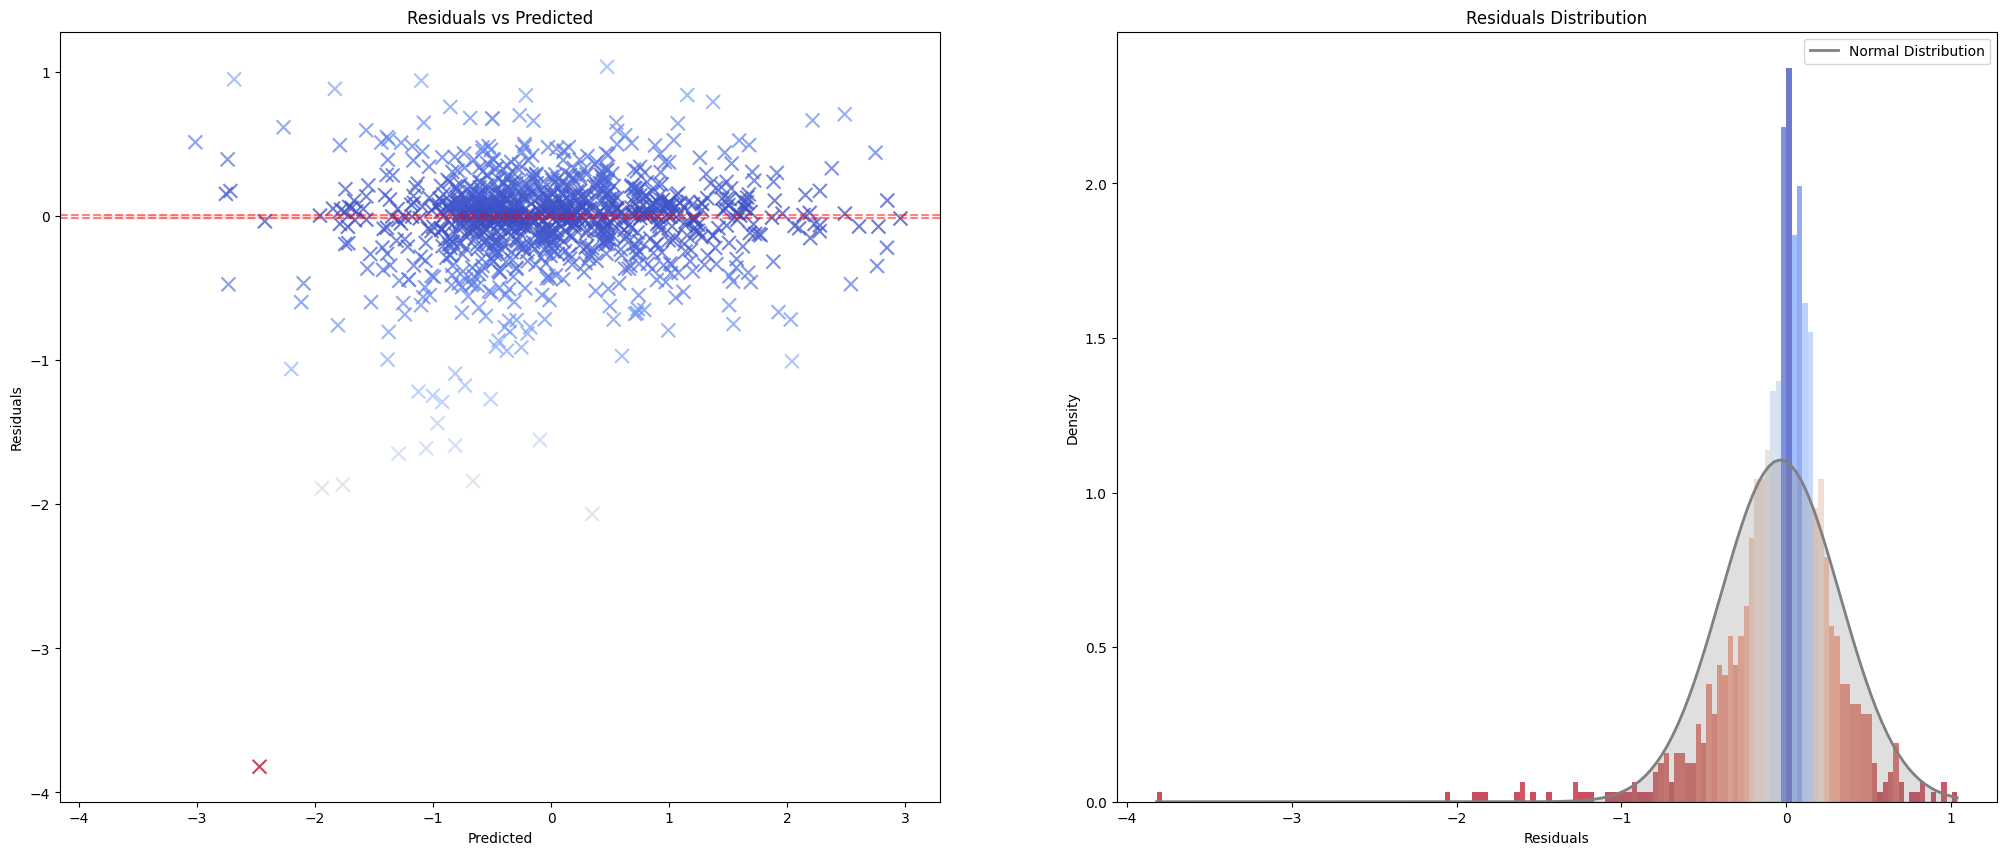

DecisionTreeRegressor


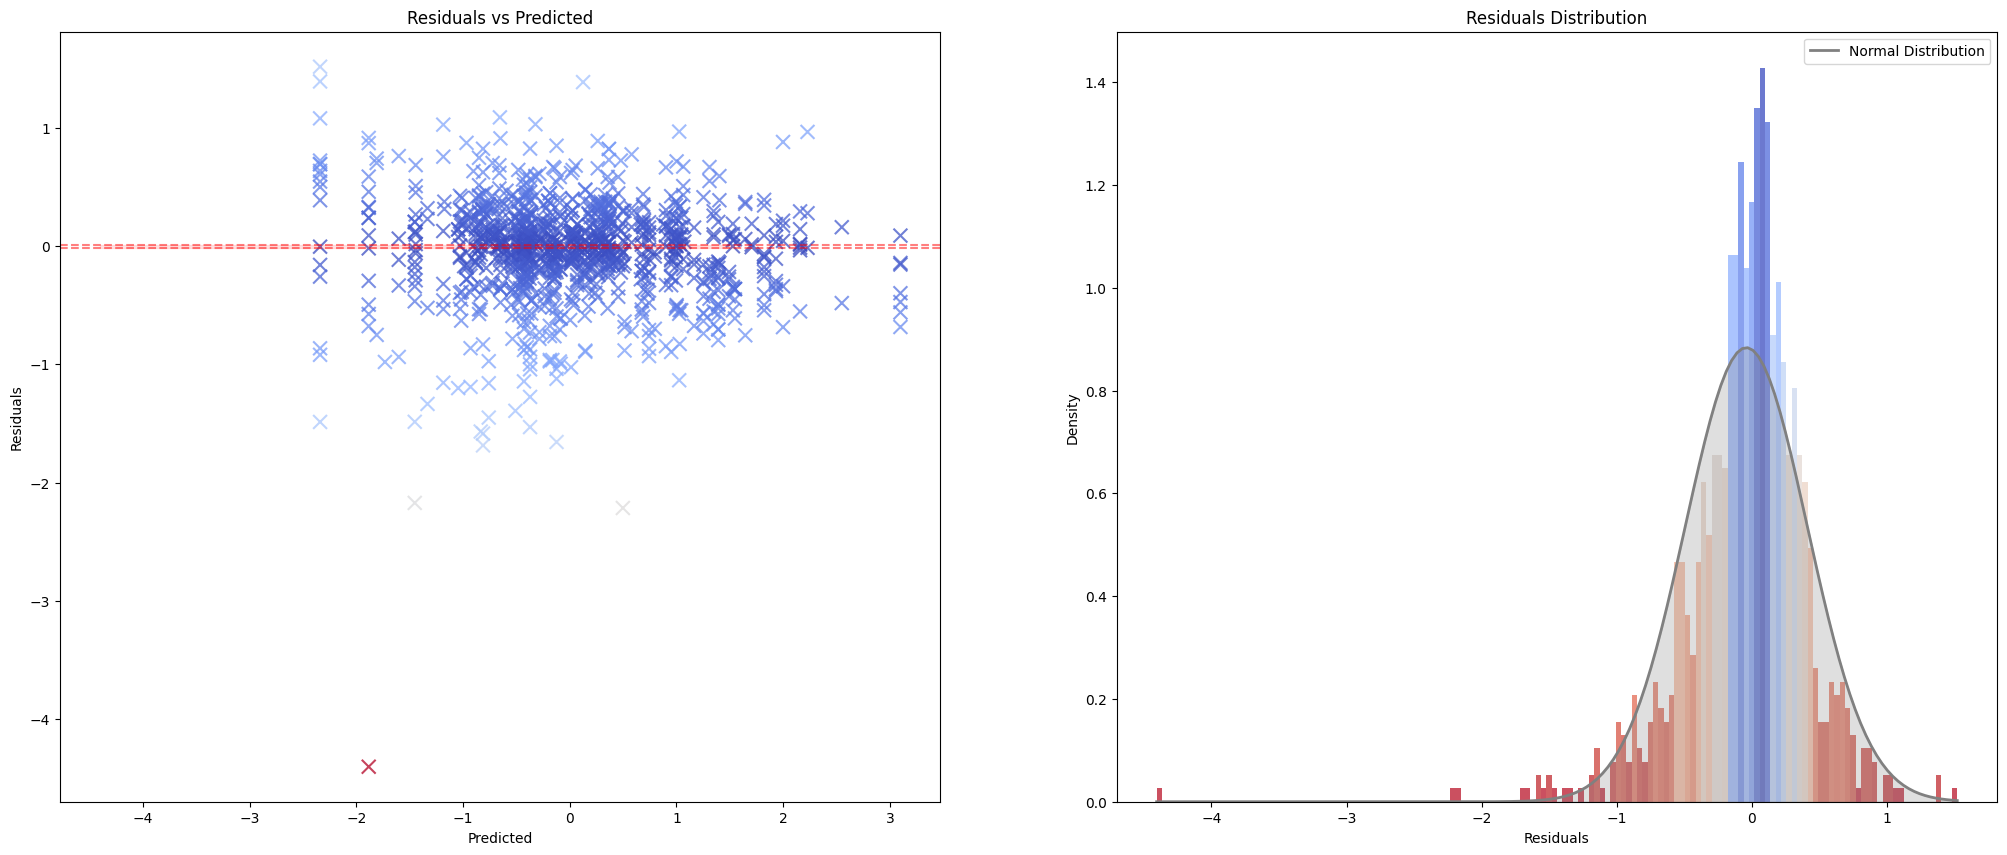

CatBoostRegressor


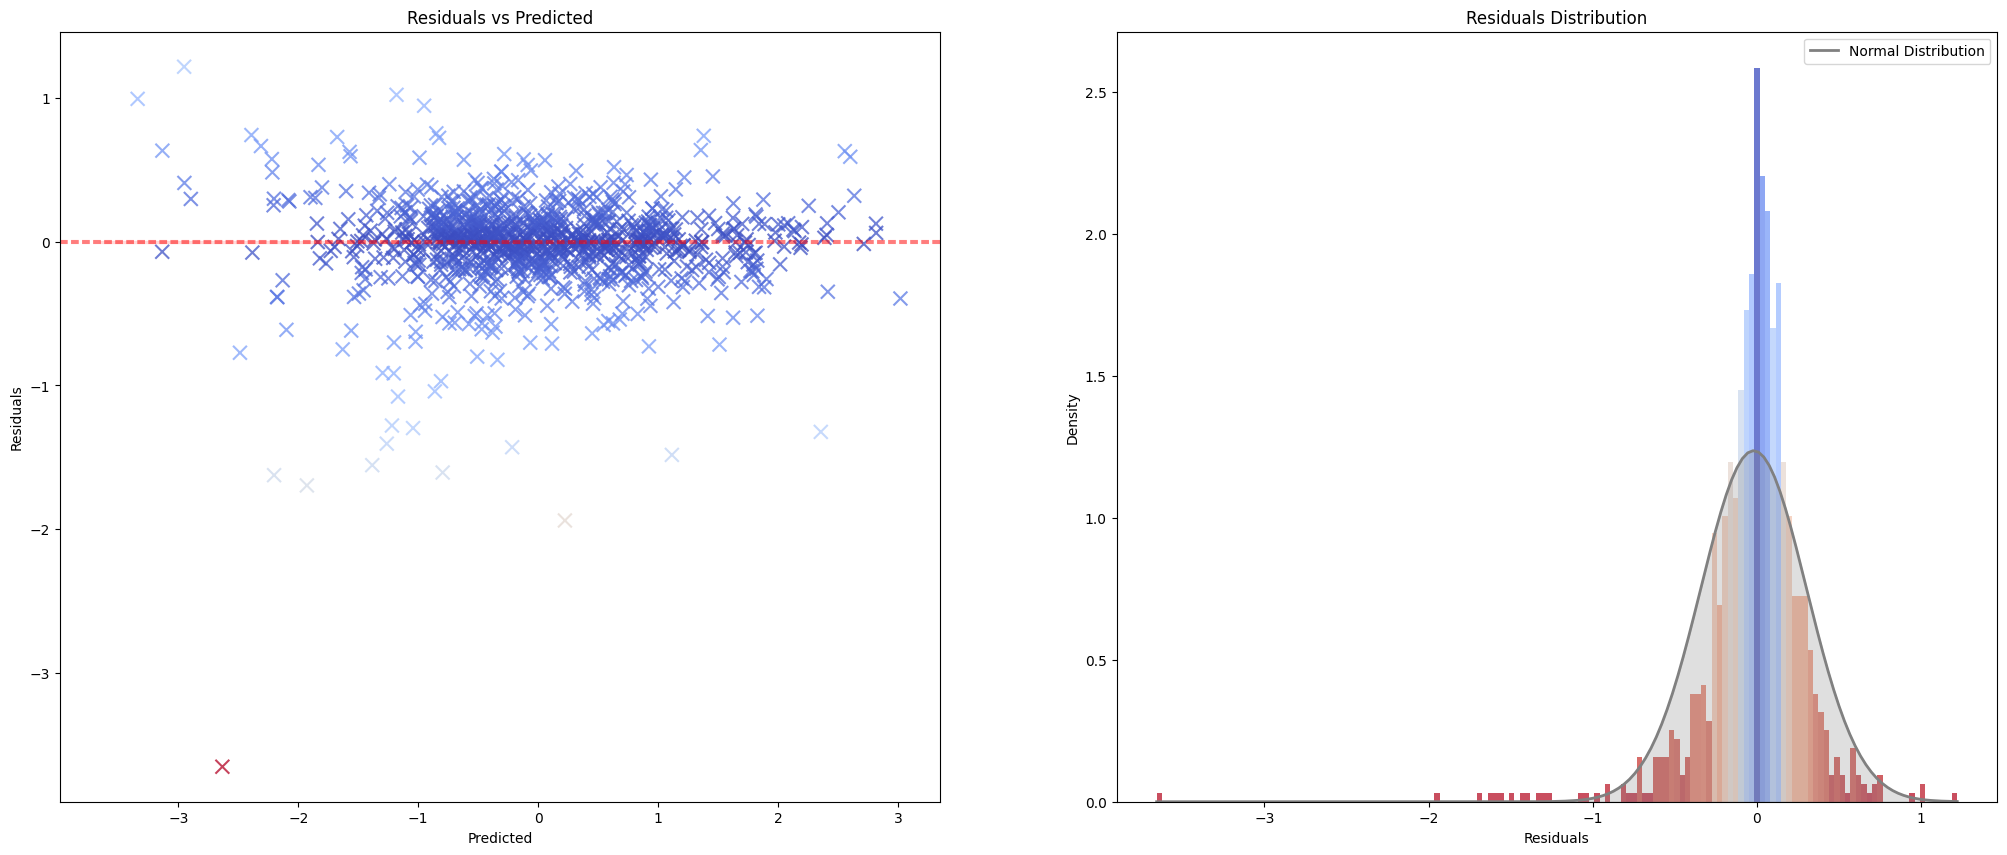

SequentialNeuralNetwork
31/31 [==============================] - 0s 1ms/step


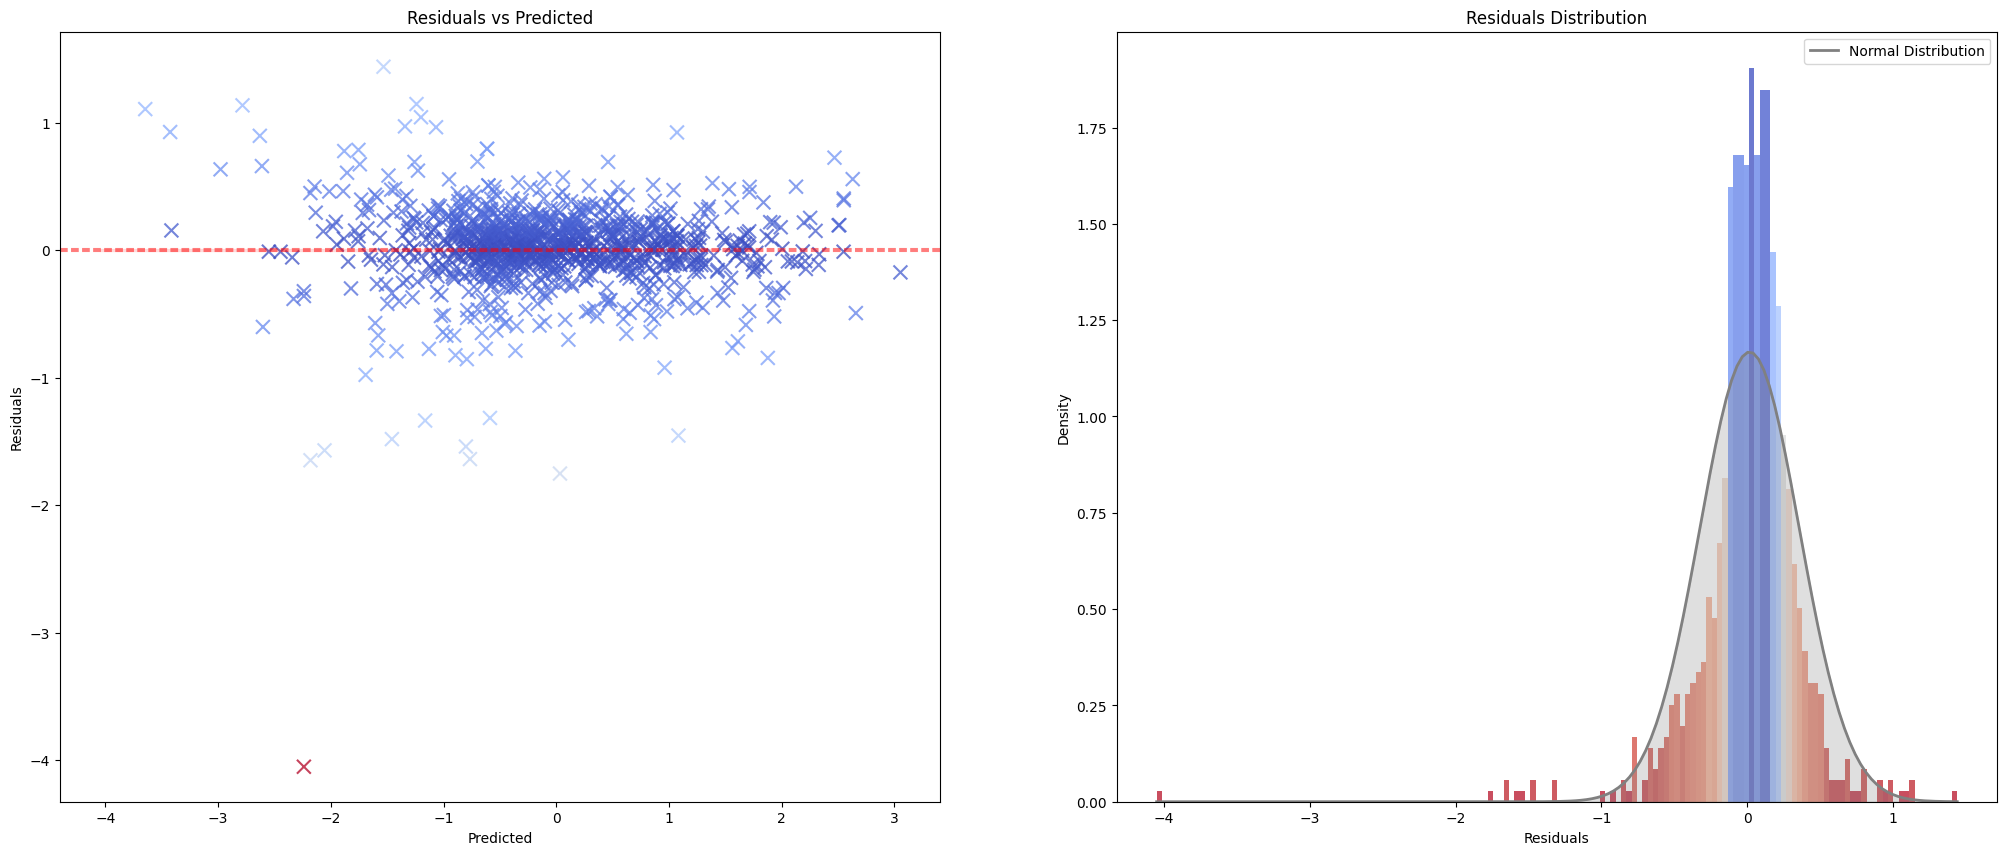

RidgeLinearRegression


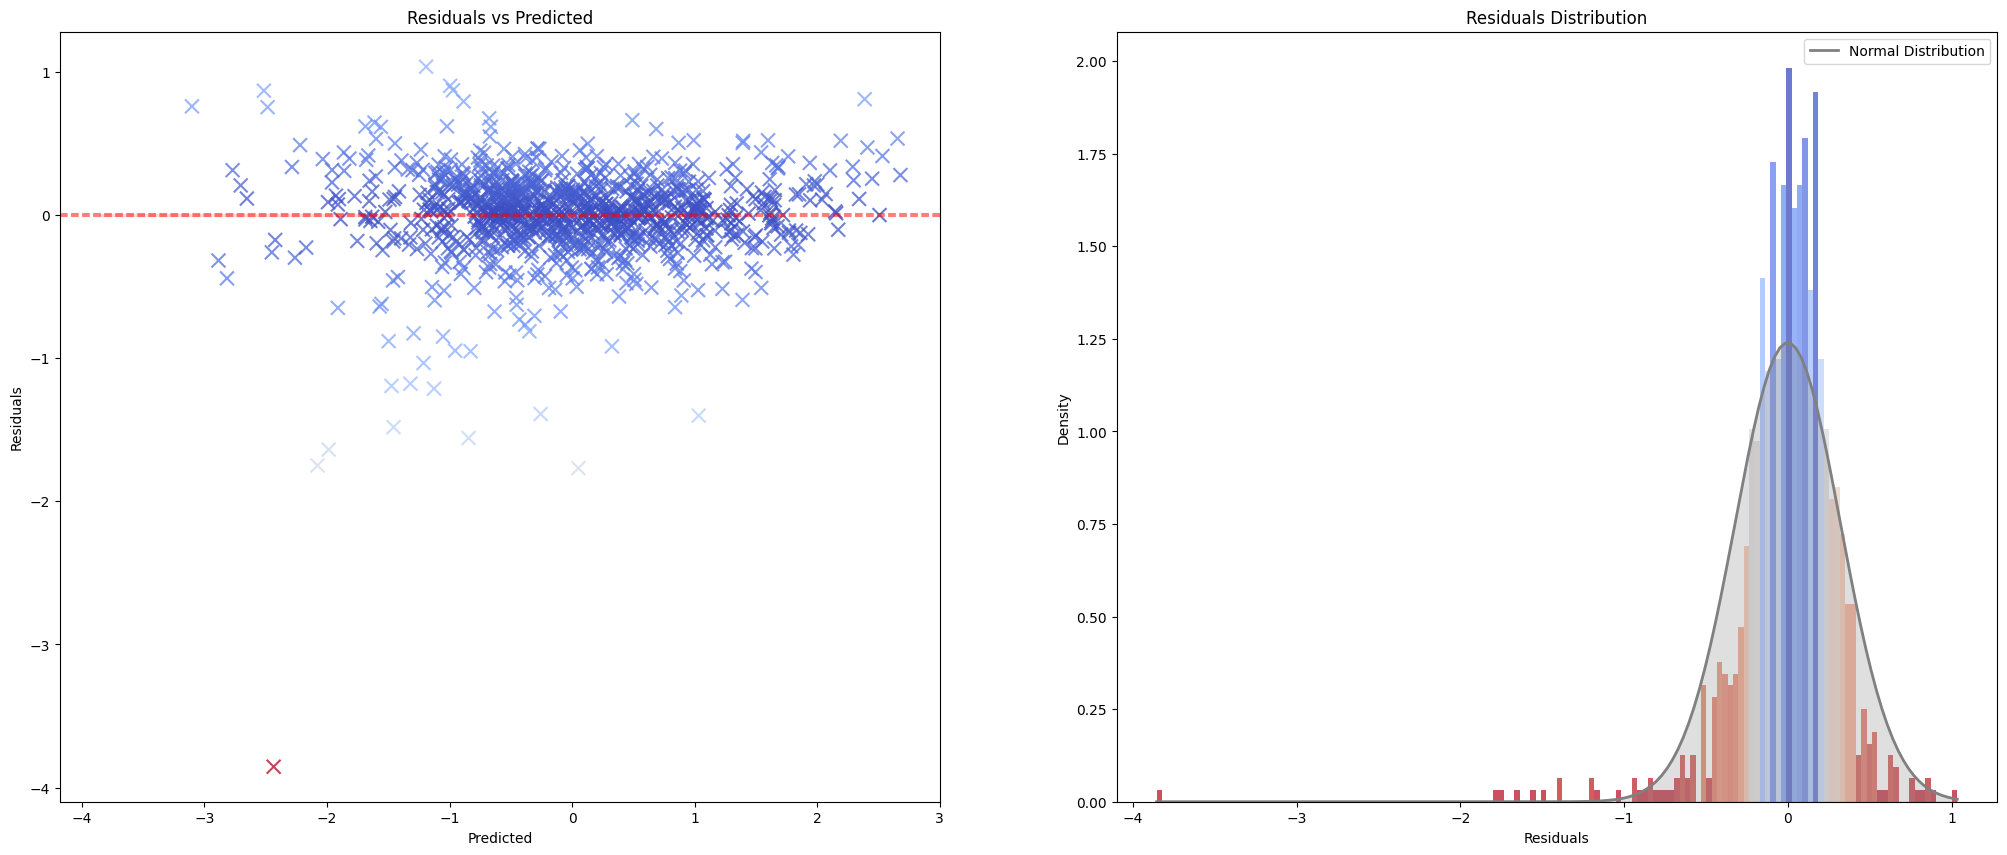

GradientBoostingRegressor


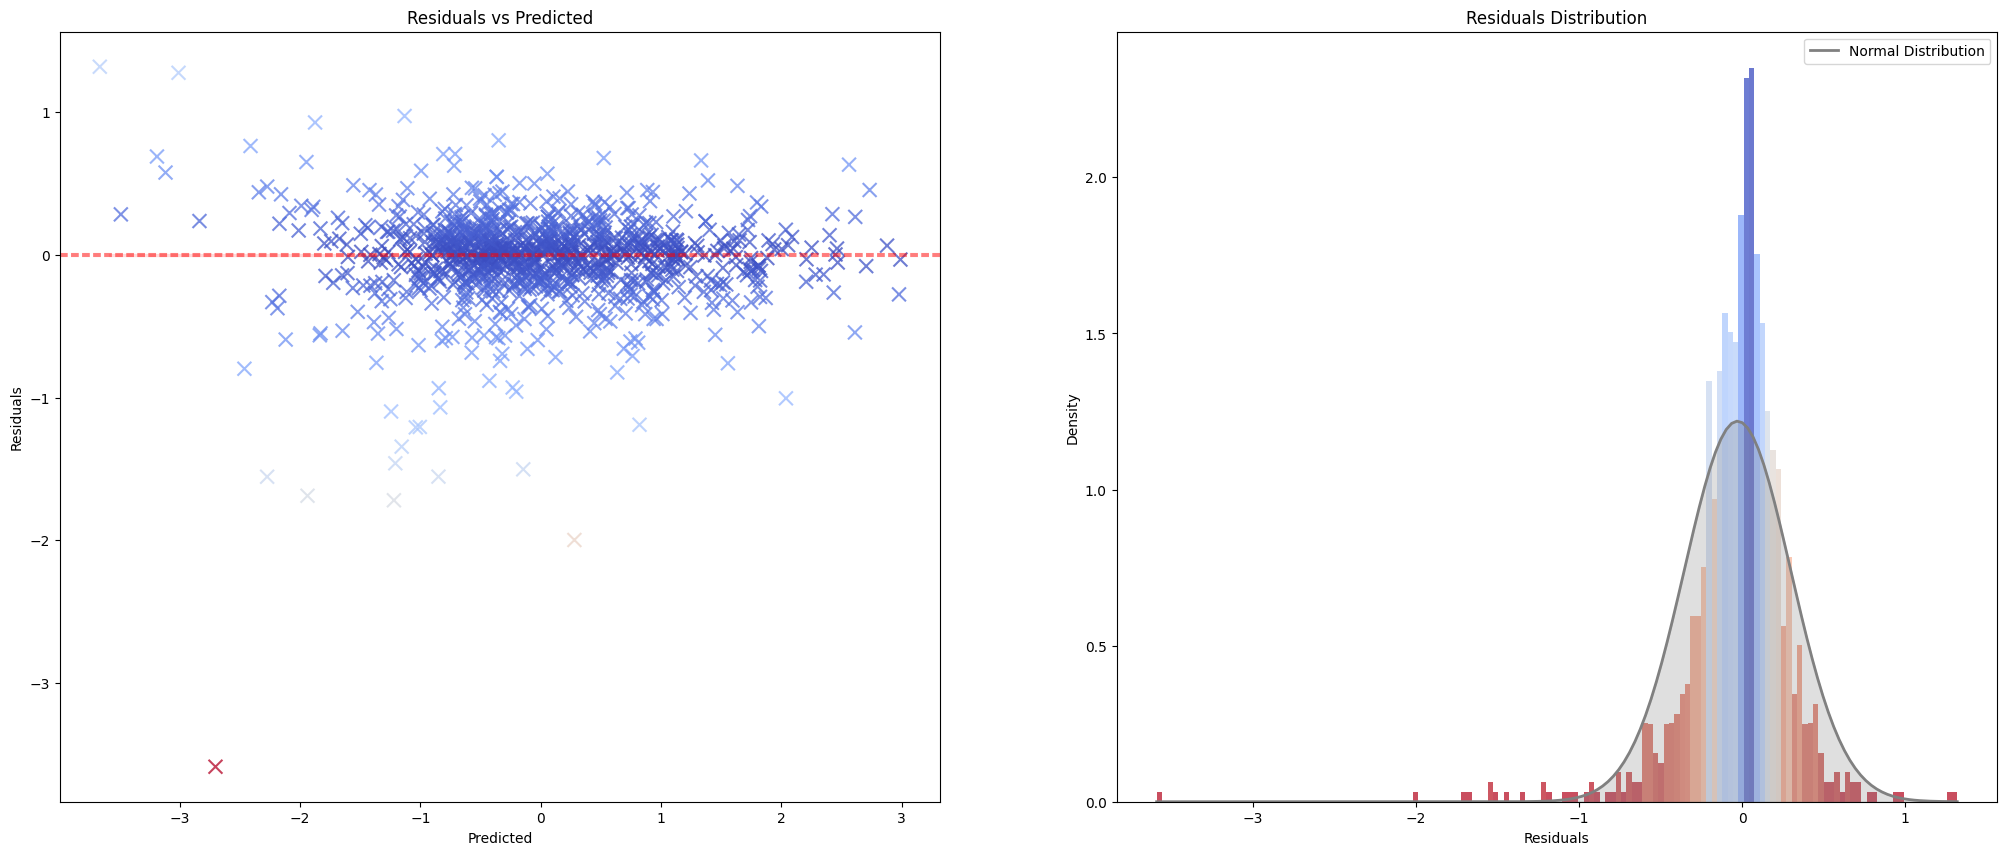

LightGBMRegressor


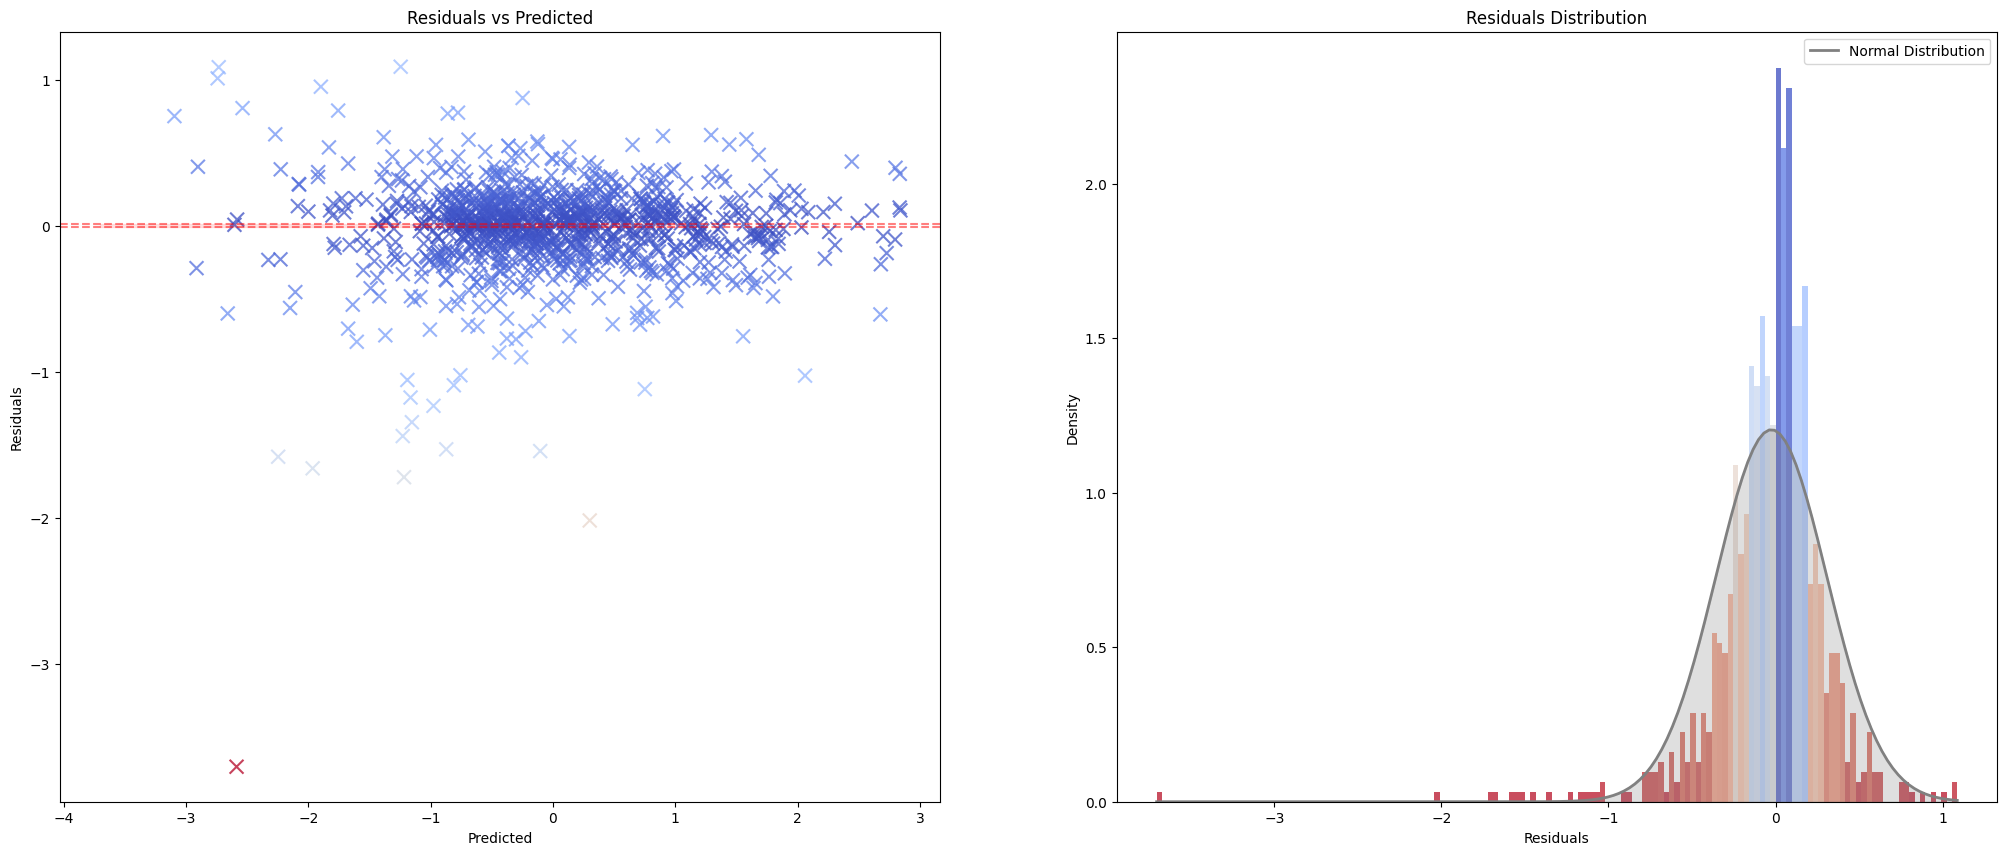

In [7]:
# Plottiamo i grafici dei residui e la loro distribuzione per i vari modelli
print("KNearestNeighborsRegressor")
KNN.plot_residuals()

print("SupportVectorMachine")
SVM.plot_residuals()

print("RandomForestRegressor")
RFR.plot_residuals()

print("DecisionTreeRegressor")
DTR.plot_residuals()

print("CatBoostRegressor")
CBR.plot_residuals()

print("SequentialNeuralNetwork")
SNN.plot_residuals()

print("RidgeLinearRegression")
RLR.plot_residuals()

print("GradientBoostingRegressor")
GBR.plot_residuals()

print("LightGBMRegressor")
LGB.plot_residuals()

Viene anche stampato il risultato sia della cv che della valutazione per ogni modello

In [8]:
print("KNearestNeighborsRegressor: ")
print(" - Cross Validation: ")
print(f"   {KNN_cv.inline()}")
print(" - Evaluation: ")
print(f"   {KNN_res.inline()}", end="\n\n")

print("SupportVectorMachine: ")
print(" - Cross Validation: ")
print(f"   {SVM_cv.inline()}")
print(" - Evaluation: ")
print(f"   {SVM_res.inline()}", end="\n\n")

print("RandomForestRegressor: ")
print(" - Cross Validation: ")
print(f"   {RFR_cv.inline()}")
print(" - Evaluation: ")
print(f"   {RFR_res.inline()}", end="\n\n")

print("DecisionTreeRegressor: ")
print(" - Cross Validation: ")
print(f"   {DTR_cv.inline()}")
print(" - Evaluation: ")
print(f"   {DTR_res.inline()}", end="\n\n")

print("CatBoostRegressor: ")
print(" - Cross Validation: ")
print(f"   {CBR_cv.inline()}")
print(" - Evaluation: ")
print(f"   {CBR_res.inline()}", end="\n\n")

print("SequentialNeuralNetwork: ")
print(" - Cross Validation: ")
print(f"   {SNN_cv.inline()}")
print(" - Evaluation: ")
print(f"   {SNN_res.inline()}", end="\n\n")

print("RidgeLinearRegression: ")
print(" - Cross Validation: ")
print(f"   {RLR_cv.inline()}")
print(" - Evaluation: ")
print(f"   {RLR_res.inline()}", end="\n\n")

print("GradientBoostingRegressor: ")
print(" - Cross Validation: ")
print(f"   {GBR_cv.inline()}")
print(" - Evaluation: ")
print(f"   {GBR_res.inline()}", end="\n\n")

print("LightGBMRegressor: ")
print(" - Cross Validation: ")
print(f"   {LGB_cv.inline()}")
print(" - Evaluation: ")
print(f"   {LGB_res.inline()}", end="\n\n")

KNearestNeighborsRegressor: 
 - Cross Validation: 
   r2: 0.84642  -  explained_variance: 0.84964  -  rmse: 0.38495  -  mae: 0.19051  -  max_error: 1.86696
 - Evaluation: 
   r2: 0.84755  -  explained_variance: 0.84776  -  rmse: 0.39460  -  mae: 0.17548  -  max_error: 4.29665

SupportVectorMachine: 
 - Cross Validation: 
   r2: 0.92645  -  explained_variance: 0.92838  -  rmse: 0.26636  -  mae: 0.13945  -  max_error: 1.32095
 - Evaluation: 
   r2: 0.89536  -  explained_variance: 0.89603  -  rmse: 0.32692  -  mae: 0.14503  -  max_error: 4.00802

RandomForestRegressor: 
 - Cross Validation: 
   r2: 0.88639  -  explained_variance: 0.88845  -  rmse: 0.33114  -  mae: 0.16601  -  max_error: 1.76247
 - Evaluation: 
   r2: 0.87126  -  explained_variance: 0.87250  -  rmse: 0.36261  -  mae: 0.14925  -  max_error: 3.82134

DecisionTreeRegressor: 
 - Cross Validation: 
   r2: 0.79786  -  explained_variance: 0.80084  -  rmse: 0.43960  -  mae: 0.21985  -  max_error: 2.20613
 - Evaluation: 
   r2: 0.7

#### Ricerca degli outliers

Come si puo notare nei plot dei residui, in ogni singolo grafo appare almeno un punto che si discosta notevolmente dalla correttezza della predizione. Per capire meglio di che si tratta ora estraiamo il valore peggiore della predizione di ogni modello e li confrontiamo fra loro.

In [9]:
#Prendiamo le 10 peggiori predizioni per ogni modello
KNN_out = KNN.get_predictions(n_pred=10, best=False)
SVM_out = SVM.get_predictions(n_pred=10, best=False)
RFR_out = RFR.get_predictions(n_pred=10, best=False)
DTR_out = DTR.get_predictions(n_pred=10, best=False)
CBR_out = CBR.get_predictions(n_pred=10, best=False)
SNN_out = SNN.get_predictions(n_pred=10, best=False)
RLR_out = RLR.get_predictions(n_pred=10, best=False)
GBR_out = GBR.get_predictions(n_pred=10, best=False)
LGB_out = LGB.get_predictions(n_pred=10, best=False)

knn_out = KNN_out.T.columns.to_numpy()
svm_out = SVM_out.T.columns.to_numpy()
rfr_out = RFR_out.T.columns.to_numpy()
dtr_out = DTR_out.T.columns.to_numpy()
cbr_out = CBR_out.T.columns.to_numpy()
snn_out = SNN_out.T.columns.to_numpy()
rlr_out = RLR_out.T.columns.to_numpy()
gbr_out = GBR_out.T.columns.to_numpy()
lgb_out = LGB_out.T.columns.to_numpy()

# Calcola l'unione degli outliers
outliers = np.concatenate((knn_out, svm_out, rfr_out, dtr_out, cbr_out, rlr_out, gbr_out, snn_out, lgb_out))

# Mostra gli outliers
raw.loc[outliers].T

31/31 [==============================] - 0s 2ms/step


2268                                  1991  \
MS_SubClass         Split_or_Multilevel  One_and_Half_Story_Finished_All_Ages   
MS_Zoning       Residential_Low_Density            Residential_Medium_Density   
Lot_Frontage                         73                                    60   
Lot_Area                           9590                                  9600   
Street                             Pave                                  Pave   
...                                 ...                                   ...   
Sale_Type                         'WD '                                 'WD '   
Sale_Condition                   Normal                                Normal   
Sale_Price                       187500                                125000   
Longitude                    -93.646788                            -93.617061   
Latitude                      41.996089                             42.029218   

                                                2199  \
MS_SubClass     One_and_Half_Story_Finished_All_Ages   
MS_Zoning                    Residential_Low_Density   
Lot_Frontage                                      51   
Lot_Area                                        6821   
Street                                          Pave   
...                                              ...   
Sale_Type                                      'WD '   
Sale_Condition                                Normal   
Sale_Price                                    146500   
Longitude                                  -93.64672   
Latitude                                   42.017889   

                                        1038                          1046  \
MS_SubClass     One_Story_PUD_1946_and_Newer  One_Story_PUD_1946_and_Newer   
MS_Zoning           Residential_High_Density       Residential_Low_Density   
Lot_Frontage                              34                            53   
Lot_Area                                4060                          4043   
Street                                  Pave                          Pave   
...                                      ...                           ...   
Sale_Type                                COD                           COD   
Sale_Condition                       Abnorml                       Abnorml   
Sale_Price                            181000                        140000   
Longitude                         -93.624873                    -93.627234   
Latitude                           42.054693                     42.050001   

                                        1047  \
MS_SubClass     Two_Story_PUD_1946_and_Newer   
MS_Zoning            Residential_Low_Density   
Lot_Frontage                              24   
Lot_Area                                2308   
Street                                  Pave   
...                                      ...   
Sale_Type                              'WD '   
Sale_Condition                        Normal   
Sale_Price                            143000   
Longitude                         -93.625986   
Latitude                            42.05068   

                                                735   \
MS_SubClass     One_and_Half_Story_Finished_All_Ages   
MS_Zoning                 Residential_Medium_Density   
Lot_Frontage                                      50   
Lot_Area                                        6000   
Street                                          Pave   
...                                              ...   
Sale_Type                                      'WD '   
Sale_Condition                                Normal   
Sale_Price                                    117000   
Longitude                                 -93.622513   
Latitude                                    42.03329   

                                    2401                     777   \
MS_SubClass     Two_Story_1946_and_Newer      Split_or_Multilevel   
MS_Zoning        Residential_Low_Density  Residential_Low_Densit

Visualizziamo le caratteristiche che potrebbero interessarci di più (alcune sono state escluse perché costanti tra di loro):

In [10]:
# Estraiamo gli outliers comuni ai diversi modelli
all_out = [knn_out, svm_out, rfr_out, dtr_out, cbr_out, rlr_out, gbr_out, snn_out, lgb_out]

outliers = all_out[0]
for i in range(1, len(all_out)):
  outliers = np.intersect1d(outliers, all_out[i])

# Mostriamo gli outliers
raw.loc[outliers].T

1038  \
MS_SubClass     One_Story_PUD_1946_and_Newer   
MS_Zoning           Residential_High_Density   
Lot_Frontage                              34   
Lot_Area                                4060   
Street                                  Pave   
...                                      ...   
Sale_Type                                COD   
Sale_Condition                       Abnorml   
Sale_Price                            181000   
Longitude                         -93.624873   
Latitude                           42.054693   

                                                1991  \
MS_SubClass     One_and_Half_Story_Finished_All_Ages   
MS_Zoning                 Residential_Medium_Density   
Lot_Frontage                                      60   
Lot_Area                                        9600   
Street                                          Pave   
...                                              ...   
Sale_Type                                      'WD '   
Sale_Condition                                Normal   
Sale_Price                                    125000   
Longitude                                 -93.617061   
Latitude                                   42.029218   

                                                2199                     2268  \
MS_SubClass     One_and_Half_Story_Finished_All_Ages      Split_or_Multilevel   
MS_Zoning                    Residential_Low_Density  Residential_Low_Density   
Lot_Frontage                                      51                       73   
Lot_Area                                        6821                     9590   
Street                                          Pave                     Pave   
...                                              ...                      ...   
Sale_Type                                      'WD '                    'WD '   
Sale_Condition                                Normal                   Normal   
Sale_Price                                    146500                   187500   
Longitude                                  -93.64672               -93.646788   
Latitude                                   42.017889                41.996089   

                                    2401  
MS_SubClass     Two_Story_1946_and_Newer  
MS_Zoning        Residential_Low_Density  
Lot_Frontage                          74  
Lot_Area                           10927  
Street                              Pave  
...                                  ...  
Sale_Type                          'WD '  
Sale_Condition                    Normal  
Sale_Price                        275000  
Longitude                     -93.650626  
Latitude                       42.059216  

[81 rows x 5 columns]

In [11]:
# Eliminiamo i duplicati dagli outliers
raw.loc[np.unique(outliers)][ ['Gr_Liv_Area', 'Lot_Area', 'Total_Bsmt_SF', 'Sale_Condition', 'Garage_Cars', 'Neighborhood',
                                'Garage_Area', 'Year_Remod_Add', 'Year_Built', 'Overall_Qual', 'Sale_Price'] ]

Gr_Liv_Area  Lot_Area  Total_Bsmt_SF Sale_Condition  Garage_Cars  \
1038         1337      4060           1405        Abnorml            2   
1991         1472      9600            702         Normal            1   
2199         1298      6821            651         Normal            1   
2268         1146      9590            868         Normal            2   
2401         1904     10927           1058         Normal            2   

            Neighborhood  Garage_Area  Year_Remod_Add  Year_Built  \
1038          North_Ames          511            1999        1998   
1991            Old_Town          250            1994        1925   
2199            Crawford          240            2005        1921   
2268          Timberland          438            2003        2003   
2401  Northridge_Heights          736            2005        2005   

       Overall_Qual  Sale_Price  
1038  Above_Average      181000  
1991        Average      125000  
2199  Above_Average      146500  
2268           Good      187500  
2401      Very_Good      275000

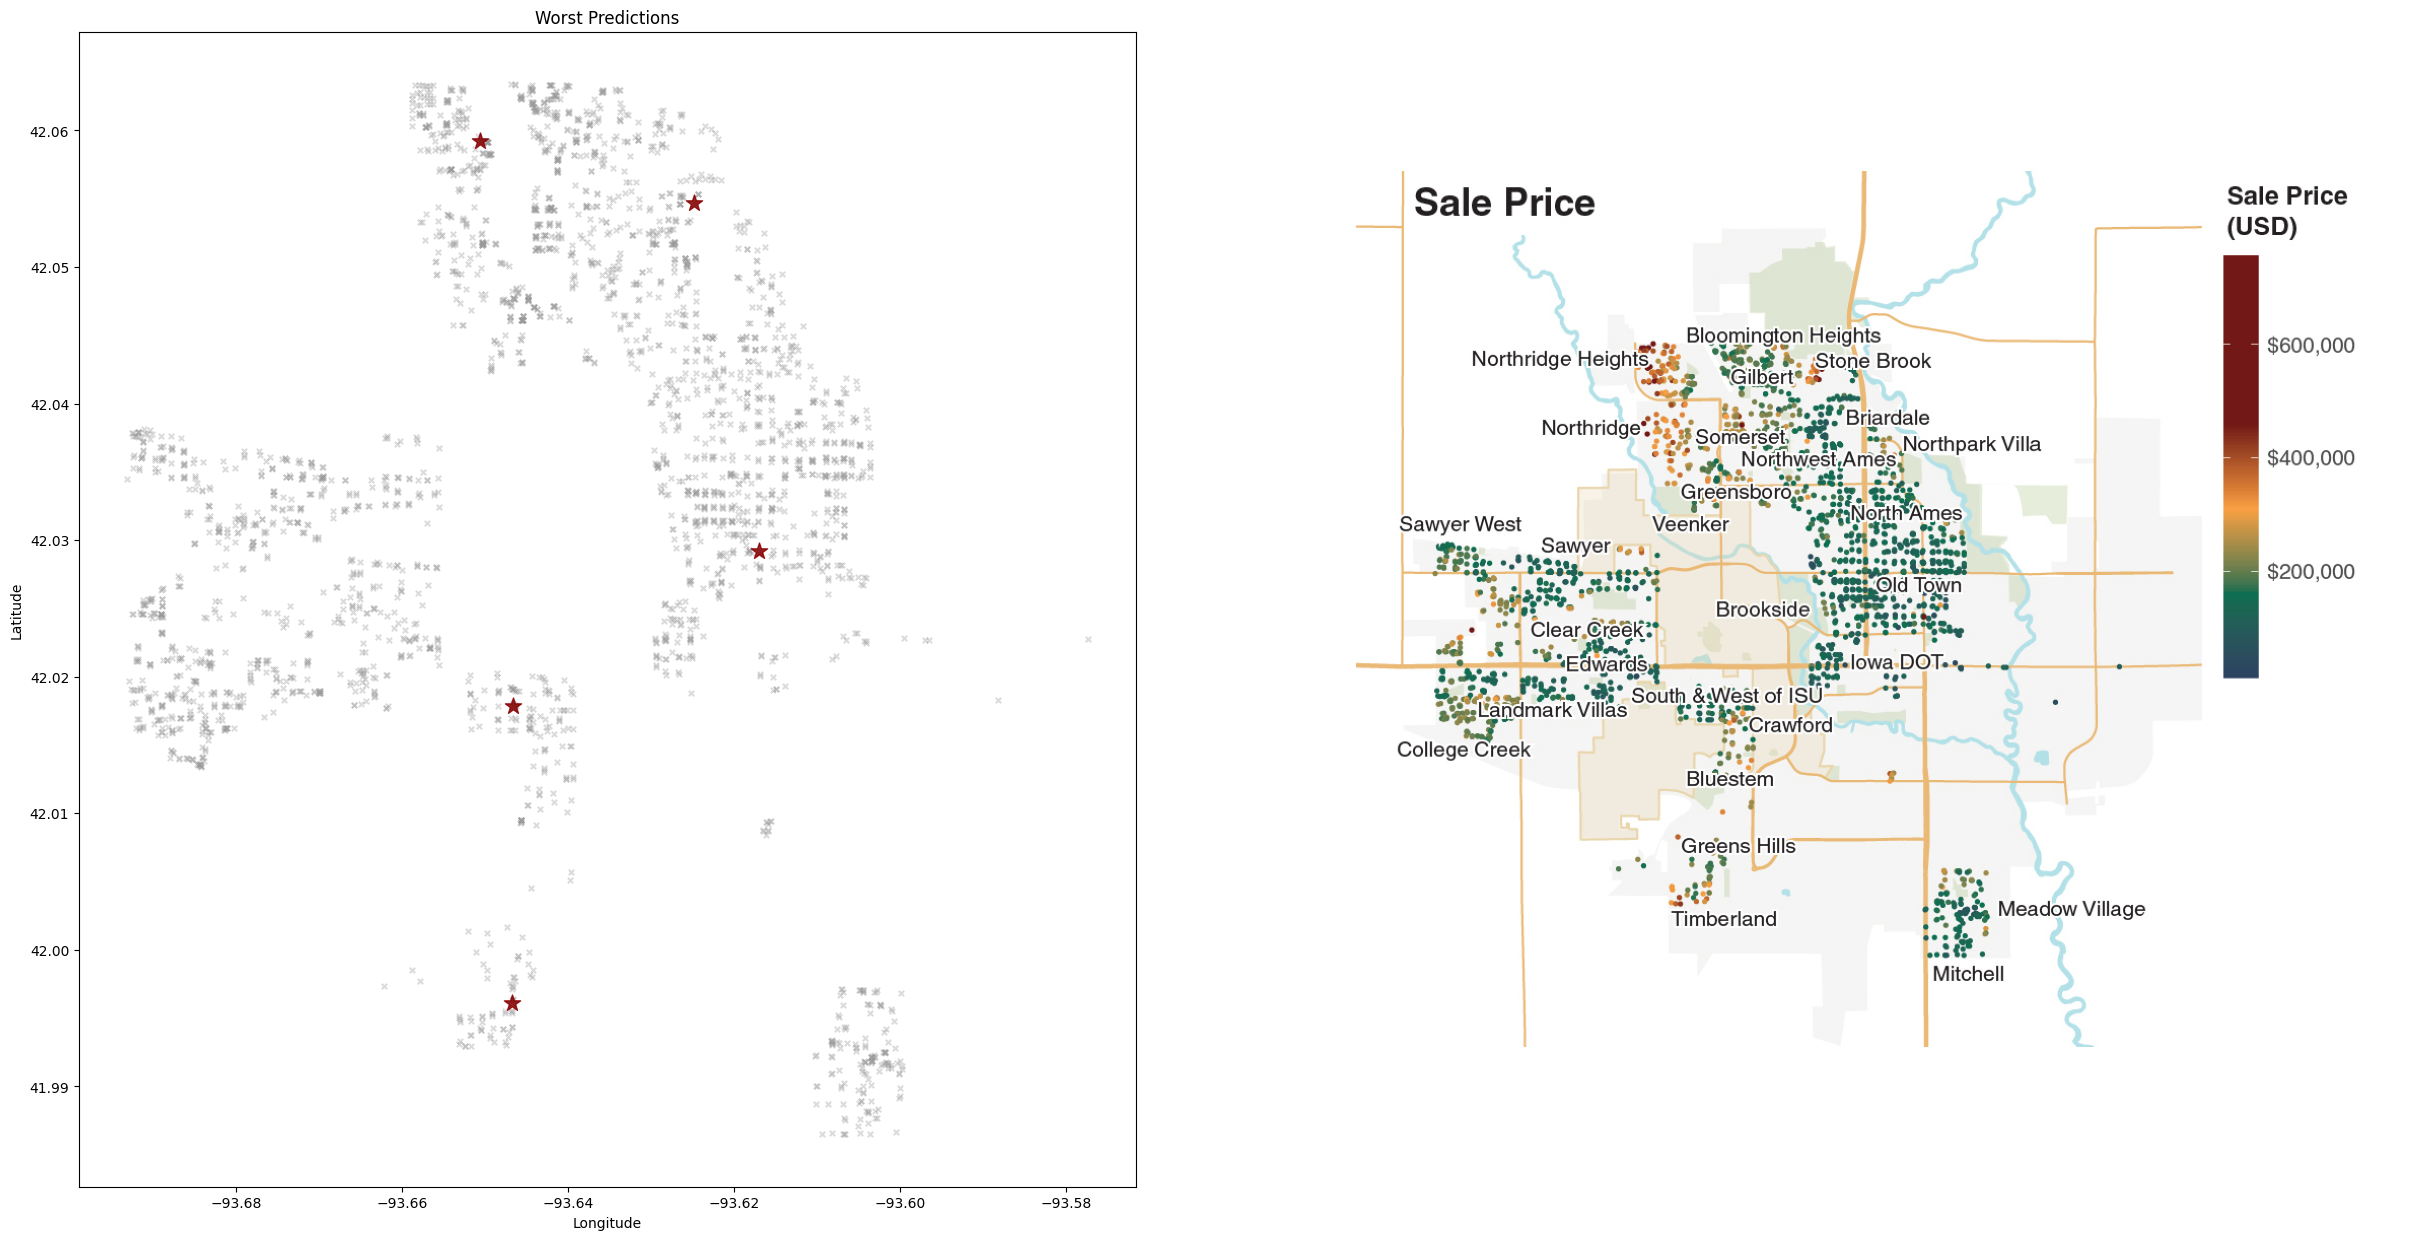

In [12]:
# Stampiamo gli outliers su una mappa con longitude e latitude

from matplotlib import pyplot as plt
# carichiamo l'immagine
img = plt.imread('data/analisi_outliers_best_predictions.jpg')

# creiamo la figure e il subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# stampiamo il primo grafico
ax1.scatter(raw["Longitude"], raw["Latitude"], alpha=0.35, s=15, marker='x', c="#999")
ax1.scatter(raw.loc[outliers]["Longitude"], raw.loc[outliers]["Latitude"], c="#800", marker='*', s=150, alpha=0.85)
ax1.set_title("Worst Predictions")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# stampiamo l'immagine
ax2.imshow(img)
ax2.axis('off')


plt.show()


#### Ricerca delle predizioni migliori

Facciamo la stessa cosa ma anche per le migliori predizioni di ogni modello.  
Prenderemo per ogni modello la migliore predizione:

In [13]:
#Prendiamo la predizione migliore (una) per ogni modello
KNN_best = KNN.get_predictions(n_pred=1, best=True)
SVM_best = SVM.get_predictions(n_pred=1, best=True)
RFR_best = RFR.get_predictions(n_pred=1, best=True)
DTR_best = DTR.get_predictions(n_pred=1, best=True)
CBR_best = CBR.get_predictions(n_pred=1, best=True)
SNN_best = SNN.get_predictions(n_pred=1, best=True)
RLR_best = RLR.get_predictions(n_pred=1, best=True)
GBR_best = GBR.get_predictions(n_pred=1, best=True)
LGB_best = LGB.get_predictions(n_pred=1, best=True)

knn_best = KNN_best.T.columns.to_numpy()
svm_best = SVM_best.T.columns.to_numpy()
rfr_best = RFR_best.T.columns.to_numpy()
dtr_best = DTR_best.T.columns.to_numpy()
cbr_best = CBR_best.T.columns.to_numpy()
snn_best = SNN_best.T.columns.to_numpy()
rlr_best = RLR_best.T.columns.to_numpy()
gbr_best = GBR_best.T.columns.to_numpy()
lgb_best = LGB_best.T.columns.to_numpy()

# Calcola l'unione delle predizioni migliori
bests = np.concatenate((knn_best, svm_best, rfr_best, dtr_best, cbr_best, rlr_best, gbr_best, snn_best, lgb_best))

# Mostra le predizioni migliori
raw.loc[bests].T

31/31 [==============================] - 0s 1ms/step


918                                  1626  \
MS_SubClass     Two_Story_1945_and_Older  One_Story_1946_and_Newer_All_Styles   
MS_Zoning        Residential_Low_Density              Residential_Low_Density   
Lot_Frontage                          53                                    0   
Lot_Area                           10918                                 9556   
Street                              Pave                                 Pave   
...                                  ...                                  ...   
Sale_Type                          'WD '                                'WD '   
Sale_Condition                    Normal                               Normal   
Sale_Price                        234000                               160000   
Longitude                     -93.644636                           -93.637848   
Latitude                       42.016067                            42.059293   

                                               1604                      485   \
MS_SubClass     One_Story_1946_and_Newer_All_Styles  Two_Story_1946_and_Newer   
MS_Zoning                   Residential_Low_Density   Residential_Low_Density   
Lot_Frontage                                     60                         0   
Lot_Area                                       6600                     12224   
Street                                         Pave                      Pave   
...                                             ...                       ...   
Sale_Type                                     'WD '                     'WD '   
Sale_Condition                               Normal                    Normal   
Sale_Price                                   130500                    244000   
Longitude                                -93.603917                -93.641919   
Latitude                                   41.98811                 42.059068   

                                                2676  \
MS_SubClass     One_and_Half_Story_Finished_All_Ages   
MS_Zoning                 Residential_Medium_Density   
Lot_Frontage                                       0   
Lot_Area                                        6240   
Street                                          Pave   
...                                              ...   
Sale_Type                                      'WD '   
Sale_Condition                                Normal   
Sale_Price                                    115000   
Longitude                                  -93.62454   
Latitude                                   42.031499   

                                      2697                      481   \
MS_SubClass       One_Story_1945_and_Older  Two_Story_1946_and_Newer   
MS_Zoning       Residential_Medium_Density   Residential_Low_Density   
Lot_Frontage                            60                         0   
Lot_Area                              7200                      8174   
Street                                Pave                      Pave   
...                                    ...                       ...   
Sale_Type                            ConLI                     'WD '   
Sale_Condition                      Family                    Normal   
Sale_Price                           90000                    178000   
Longitude                       -93.626589                -93.640065   
Latitude                         42.023809                 42.063283   

                                               152   \
MS_SubClass     One_Story_1946_and_Newer_All_Styles   
MS_Zoning                   Residential_Low_Density   
Lot_Frontage                                     68   
Lot_Area                                       7922   
Street                                         Pave   
...                                             ...   
Sale_Type                                     'WD '   
Sale_Condition                              Abnorml   
Sale_Price                                   109000   
Lo

Visualizziamo le caratteristiche che potrebbero interessarci di più (alcune sono state escluse perché costanti tra di loro):

In [14]:
# Eliminiamo i duplicati dalle predizioni migliori
raw.loc[np.unique(bests)][ ['Gr_Liv_Area', 'Lot_Area', 'Total_Bsmt_SF', 'Sale_Condition', 'Garage_Cars', 'Neighborhood',
                            'Garage_Area', 'Year_Remod_Add', 'Year_Built', 'Overall_Qual', 'Sale_Price'] ]

Gr_Liv_Area  Lot_Area  Total_Bsmt_SF Sale_Condition  Garage_Cars  \
152          1057      7922           1057        Abnorml            1   
481          1342      8174            698         Normal            2   
485          2054     12224            992         Normal            2   
918          2080     10918           1276         Normal            1   
1604          816      6600            816         Normal            1   
1626         1187      9556           1168         Normal            2   
2543         1712      8393           1626         Family            2   
2676         1344      6240            896         Normal            1   
2697          984      7200            984         Family            1   

                Neighborhood  Garage_Area  Year_Remod_Add  Year_Built  \
152               North_Ames          246            2007        1953   
481                  Gilbert          393            2003        2003   
485                  Gilbert          390            2000        2000   
918                 Crawford          282            2004        1926   
1604                Mitchell          264            2008        1982   
1626                 Gilbert          420            1993        1992   
2543              North_Ames          588            2005        1959   
2676               Brookside          240            1950        1936   
2697  Iowa_DOT_and_Rail_Road          308            1950        1930   

       Overall_Qual  Sale_Price  
152         Average      109000  
481            Good      178000  
485   Above_Average      244000  
918            Good      234000  
1604        Average      130500  
1626           Good      160000  
2543        Average      145000  
2676        Average      115000  
2697  Above_Average       90000

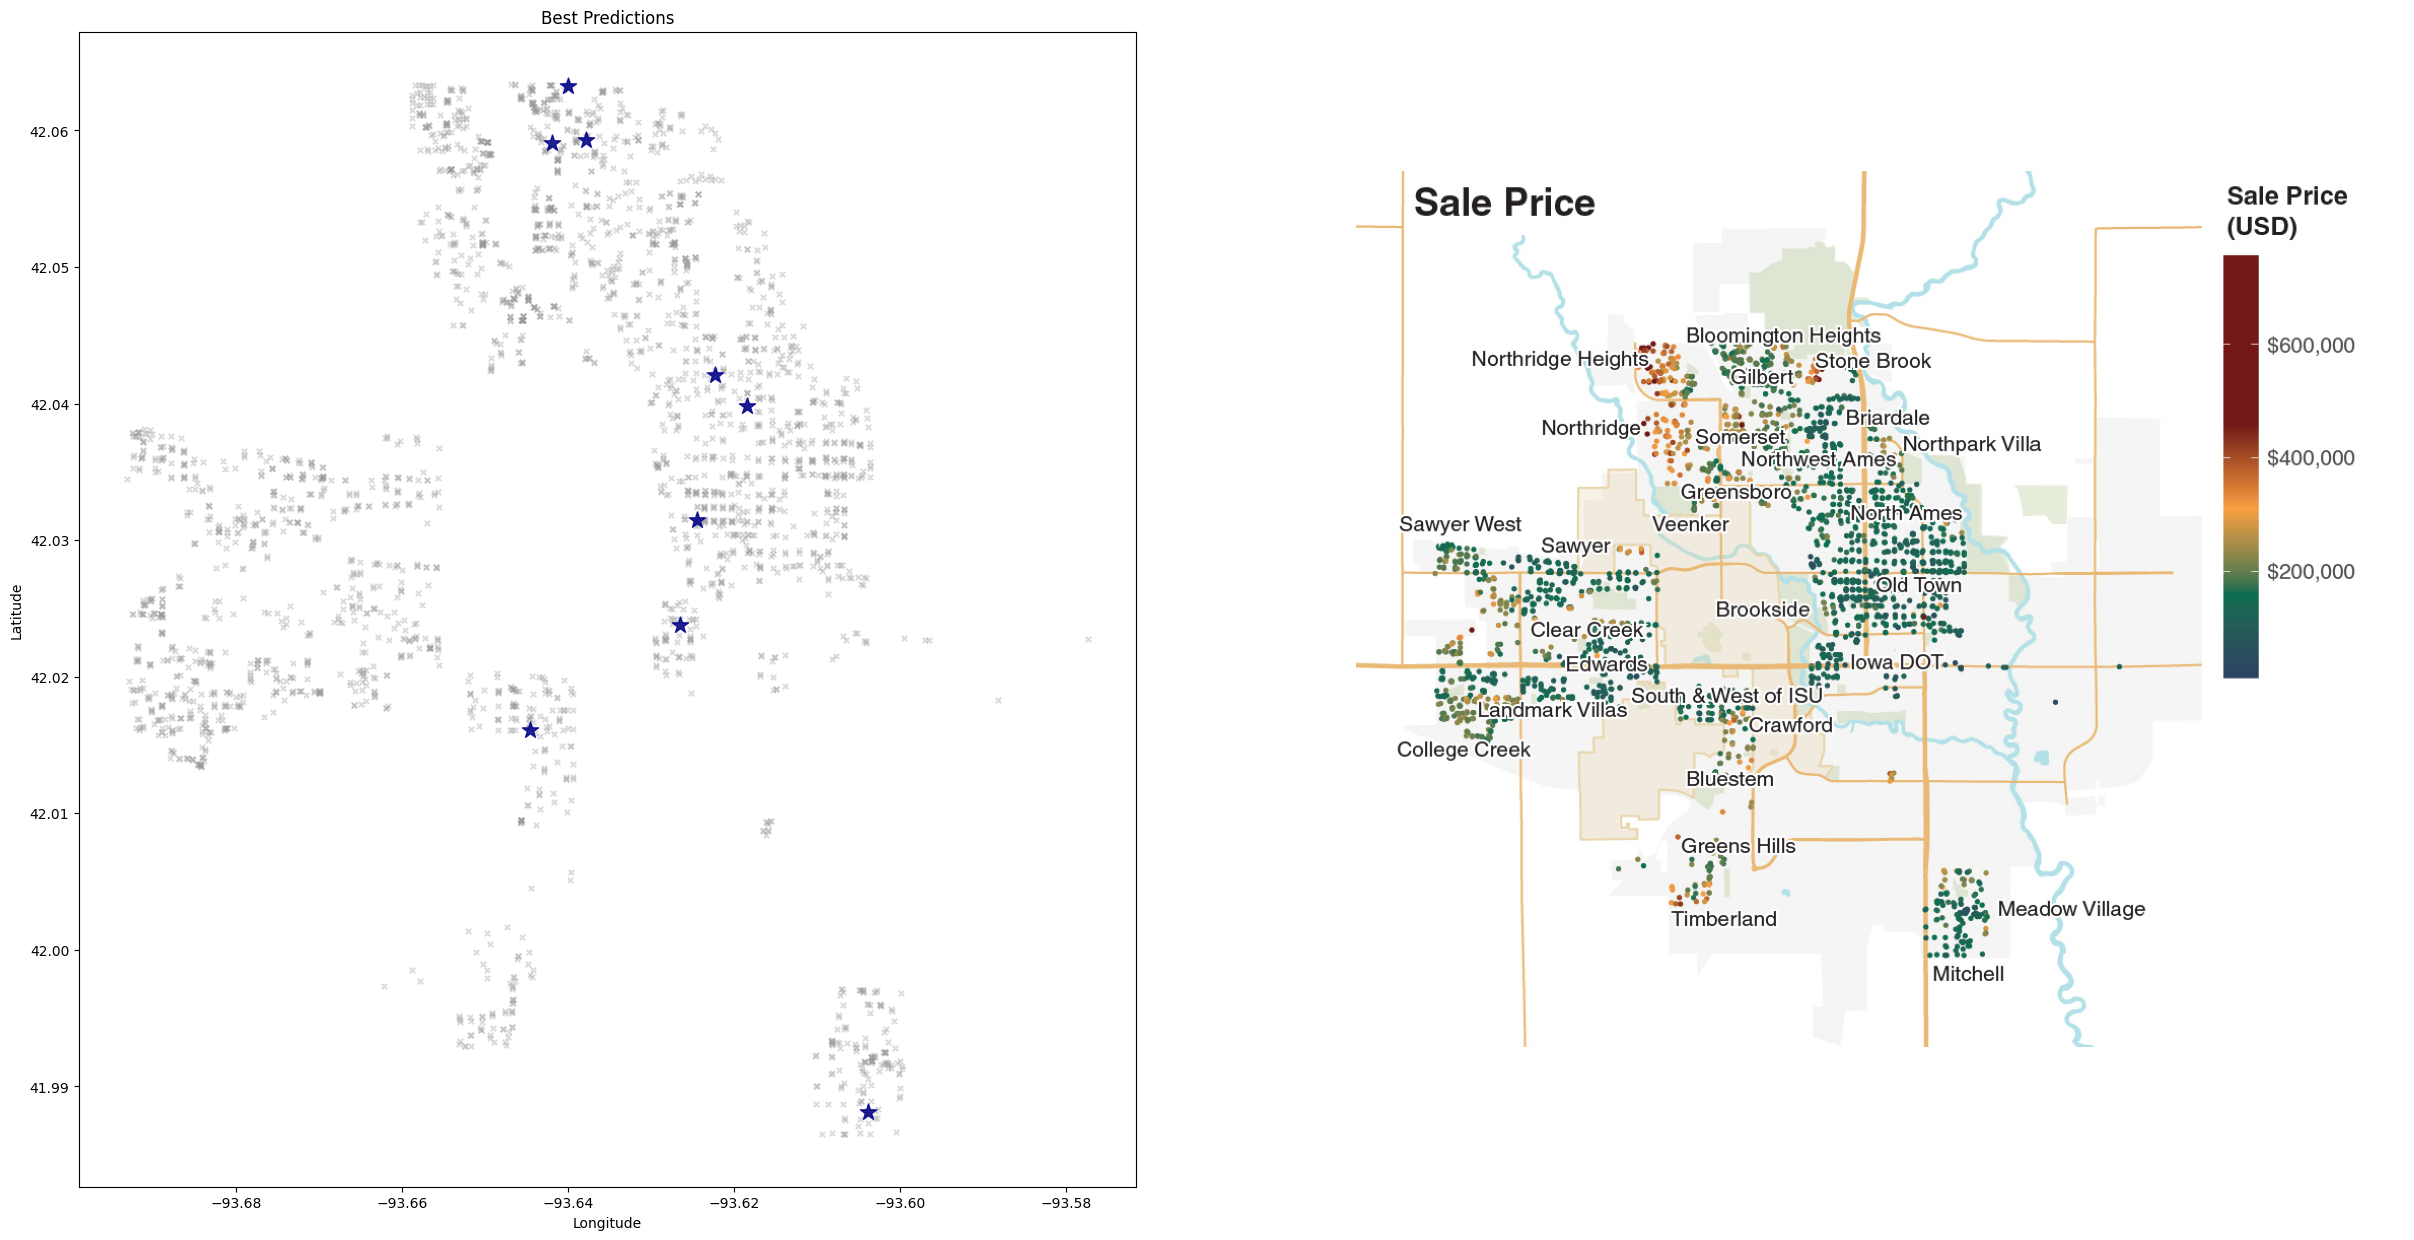

In [15]:
# Stampiamo le predizioni migliori su una mappa con longitude e latitude

from matplotlib import pyplot as plt
# carichiamo l'immagine
img = plt.imread('data/analisi_outliers_best_predictions.jpg')

# creiamo la figure e il subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 15))

# stampiamo il primo grafico
ax1.scatter(raw["Longitude"], raw["Latitude"], alpha=0.35, s=15, marker='x', c="#999")
ax1.scatter(raw.loc[bests]["Longitude"], raw.loc[bests]["Latitude"], c="#008", marker='*', s=150, alpha=0.85)
ax1.set_title("Best Predictions")
ax1.set_xlabel("Longitude")
ax1.set_ylabel("Latitude")

# stampiamo l'immagine
ax2.imshow(img)
ax2.axis('off')


plt.show()
